## **PATIENT DIABETES PREDICTION**  

### Model Training
--- 



### **Libraries**

In [34]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.utils import resample
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, roc_auc_score, classification_report, confusion_matrix
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier


import joblib
import pickle

import warnings
warnings.filterwarnings('ignore')


### **Data Loading and Inspection**

In [35]:
df = pd.read_csv("diabetes.csv")
df.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


In [36]:
df.shape

(768, 9)

In [37]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Pregnancies               768 non-null    int64  
 1   Glucose                   768 non-null    int64  
 2   BloodPressure             768 non-null    int64  
 3   SkinThickness             768 non-null    int64  
 4   Insulin                   768 non-null    int64  
 5   BMI                       768 non-null    float64
 6   DiabetesPedigreeFunction  768 non-null    float64
 7   Age                       768 non-null    int64  
 8   Outcome                   768 non-null    int64  
dtypes: float64(2), int64(7)
memory usage: 54.1 KB


In [38]:
df.describe()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
count,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000
mean,3.845052,120.894531,69.105469,20.536458,79.799479,31.992578,0.471876,33.240885,0.348958
std,3.369578,31.972618,19.355807,15.952218,115.244002,7.884160,0.331329,11.760232,0.476951
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.078000,21.000000,0.000000
25%,1.000000,99.000000,62.000000,0.000000,0.000000,27.300000,0.243750,24.000000,0.000000
50%,3.000000,117.000000,72.000000,23.000000,30.500000,32.000000,0.372500,29.000000,0.000000
75%,6.000000,140.250000,80.000000,32.000000,127.250000,36.600000,0.626250,41.000000,1.000000
max,17.000000,199.000000,122.000000,99.000000,846.000000,67.100000,2.420000,81.000000,1.000000


In [39]:
# check null/missing values
df.isna().sum()

Pregnancies                 0
Glucose                     0
BloodPressure               0
SkinThickness               0
Insulin                     0
BMI                         0
DiabetesPedigreeFunction    0
Age                         0
Outcome                     0
dtype: int64

_After data loading and inspection we find that the data types are in the correct/desired formats an in addition, there are no missing values_

### **Data Visualiation**

#### Data Distribution - Histogram

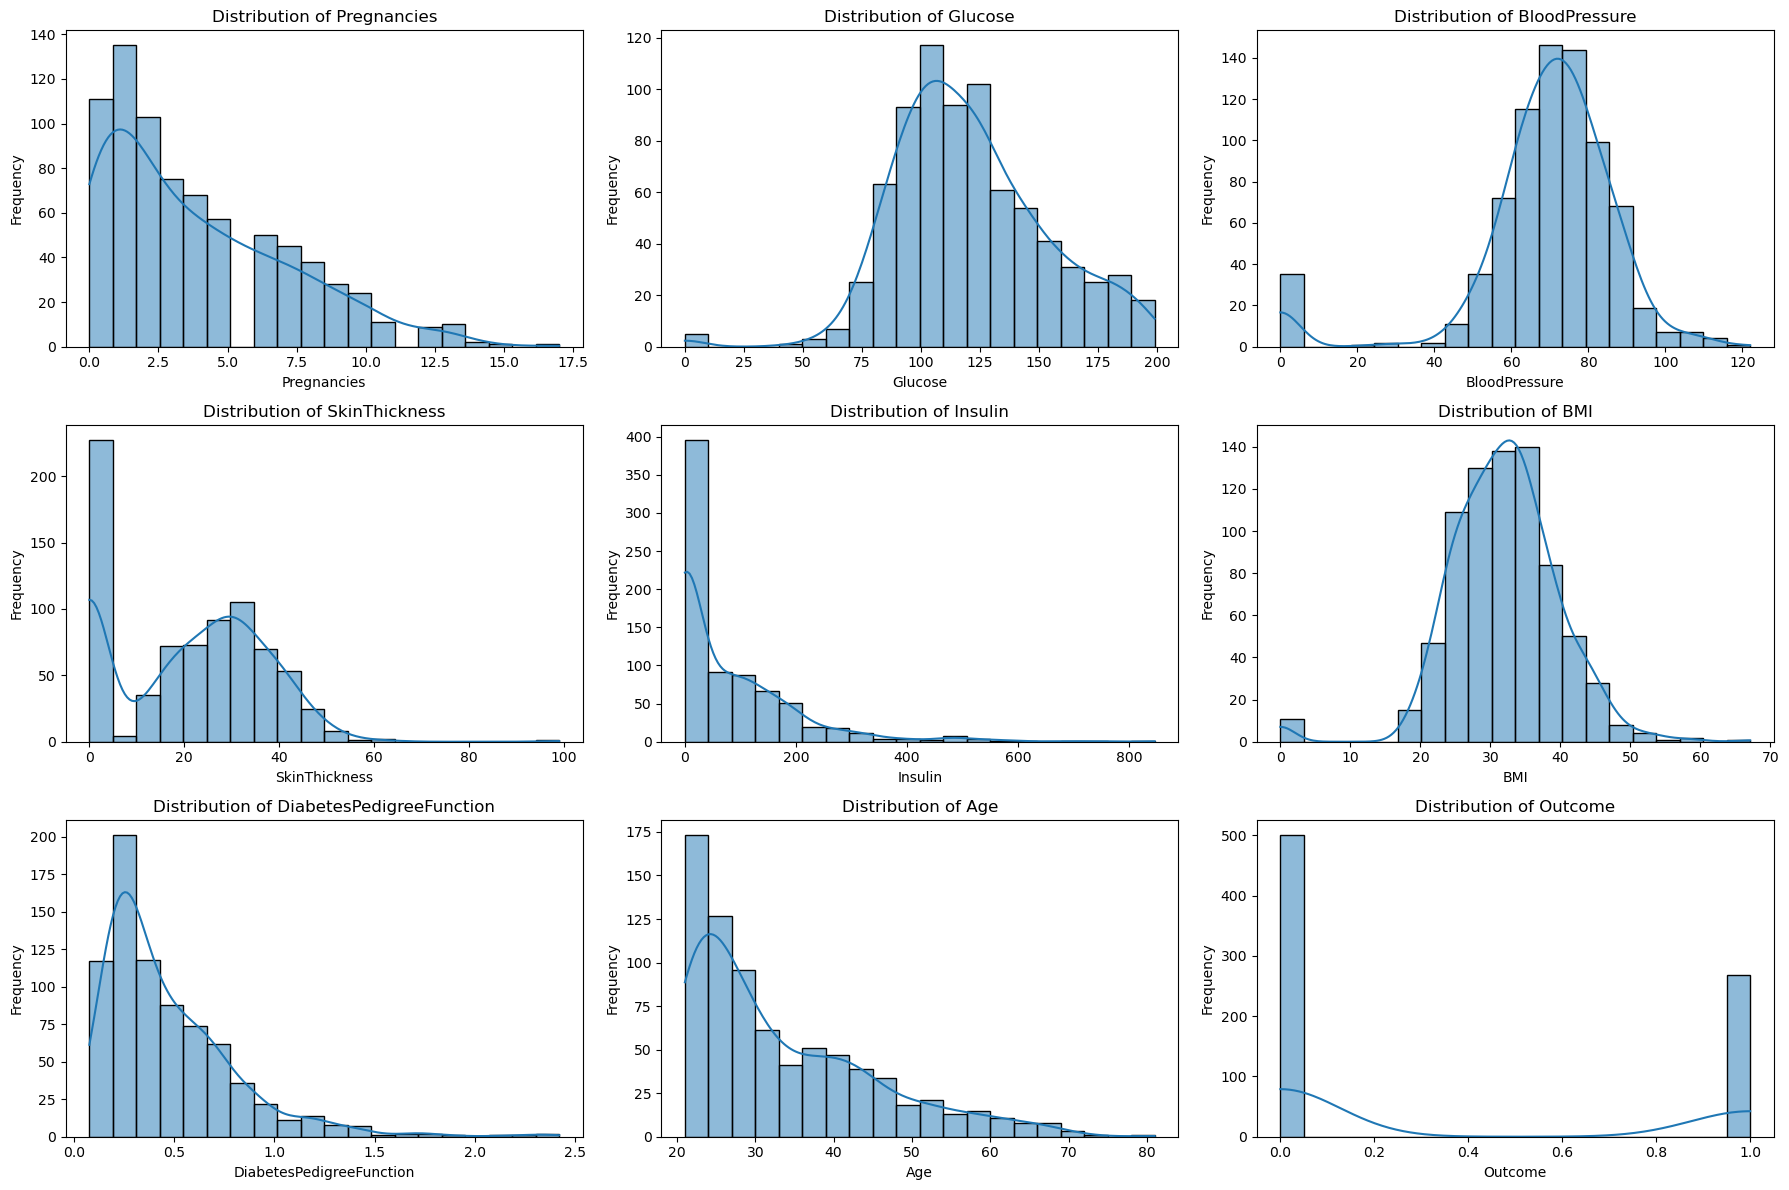

In [40]:
# List of columns to plot
columns_to_plot = df.select_dtypes(include="number")

# Create the figure
plt.figure(figsize=(18, 12))

# Iterate through the columns and create subplots
for i, column in enumerate(columns_to_plot, 1):
    plt.subplot(3, 3, i)  
    sns.histplot(df[column], kde=True, bins = 20)
    # plt.hist(heart_df[column], bins=20, edgecolor='black', color='y')
    plt.title(f'Distribution of {column}')
    plt.xlabel(column)
    plt.ylabel('Frequency')

plt.tight_layout()
plt.show()


#### Outlier Visualization - Boxplots

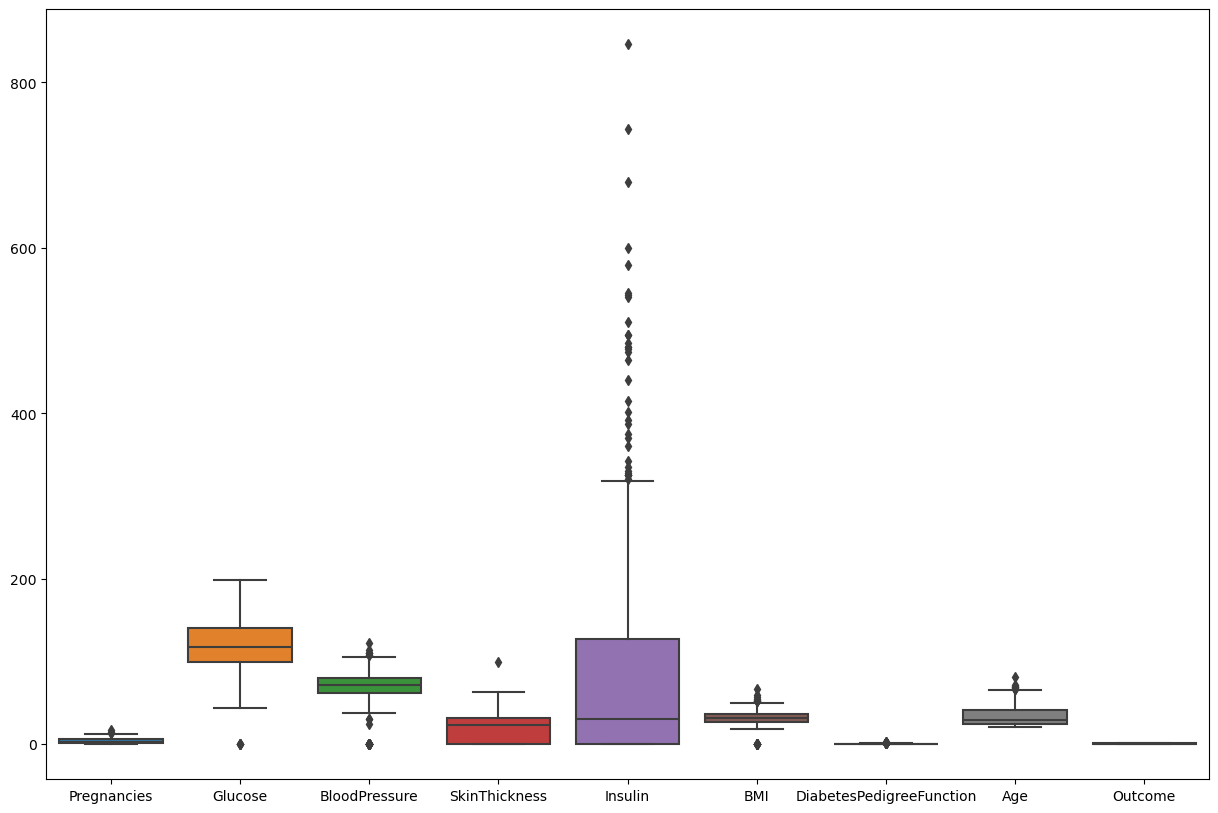

In [41]:
# create figure for boxplot
plt.figure(figsize=(15, 10))
sns.boxplot(data=df)
plt.show()

### Class Distribution - Count Plot

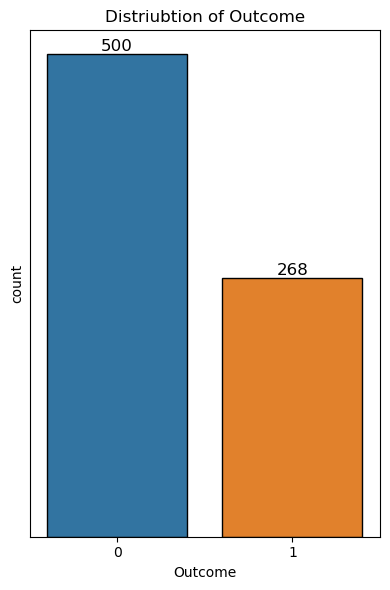

In [42]:
# create the figure
plt.figure(figsize=(4,6))

ax = sns.countplot(x=df['Outcome'], data=df, edgecolor = 'black')
plt.title(f"Distriubtion of Outcome")
plt.xlabel('Outcome')
plt.yticks([])

# add data labels
ax.bar_label(ax.containers[0], label_type='edge', fontsize = 12)
plt.tight_layout()
plt.show()

In [43]:
print(df['Outcome'].value_counts())

Outcome
0    500
1    268
Name: count, dtype: int64


In [44]:
df.groupby('Outcome').mean()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age
Outcome,,,,,,,,
0,3.298000,109.980000,68.184000,19.664000,68.792000,30.304200,0.429734,31.190000
1,4.865672,141.257463,70.824627,22.164179,100.335821,35.142537,0.550500,37.067164


In [45]:
# checking for duplicates
df[df.duplicated()]

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome


### **Preprocessing and Model Training**

### Preprocessing Steps

In [46]:
# features and target
X = df.drop(columns=['Outcome'], axis=1)
y = df['Outcome']

# train-tes split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)



In [47]:
# define numeric columns
numeric_features = df.drop(columns=['Outcome']).select_dtypes(include=['number']).columns

# define preprocessing for numeric features
numeric_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())
])

# define preprocessor
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features)
    ]
    )

# define the pipeline
pipeline = Pipeline(
    steps = [
        ('preprocessor', preprocessor),
        ()
    ]
)

In [48]:
# define the pipelines
pipelines = {
    'LogisticRegression':Pipeline([
        ('preprocessor', preprocessor),
        ('classifier', LogisticRegression())
    ]),
    'DecisionTreeClassifier': Pipeline([
        ('preprocessor', preprocessor),
        ('classifier', DecisionTreeClassifier())
    ]),
    'RandomForestClassifier': Pipeline([
        ('preprocessor', preprocessor),
        ('classifier', RandomForestClassifier())
    ]),
    'GradientBoostingClassifier': Pipeline([
        ('preprocessor', preprocessor),
        ('classifier', GradientBoostingClassifier())
    ]),
    'XGBClassifier': Pipeline([
        ('preprocessor', preprocessor),
        ('classifier', XGBClassifier())
    ])
}


In [49]:
# initialize variables to track best model
best_model_name = None
best_model_pipeline = None
best_accuracy_score = -float('inf')  #start with negative infinity
best_cv_accuracy_score = -float('inf')


# train and evaluate pipelines
for name, pipeline in pipelines.items():
    print(f"\nTraining {name}...")

    # training the pipeline
    pipeline.fit(X_train, y_train)
    
    # making predictions and evaluating accuracy
    predictions = pipeline.predict(X_test)
    accuracy = accuracy_score(y_test, predictions)
    report = classification_report(y_test, predictions)

    # performing cross-validation
    scores = cross_val_score(pipeline, X, y, cv = 6, scoring ='accuracy')
    cv_accuracy = scores.mean()

    # display results
    print(f'\n{name}:')
    print(f"Model Accuracy: {accuracy:.4f}")
    print(f'Cross-validation Accuracy: {cv_accuracy:.4f}')
    print("Classification Report")
    print(report)

    # check accuracy and cv_accuracy scores for best model
    if (accuracy > best_cv_accuracy_score) and (cv_accuracy > best_cv_accuracy_score):
        best_accuracy_score = accuracy
        best_cv_accuracy_score = cv_accuracy
        best_model_name = name
        best_model_pipeline = pipeline

# Display best model
if best_model_pipeline is not None:
    print("\nBest Model:")
    print(f"Name: {best_model_name}")
    print(f"Accuracy {best_accuracy_score:.4f}")
    print(f"Cross-validation Accuracy: {best_cv_accuracy_score:.4f}")


    # Save the best model
    joblib.dump(best_model_pipeline, f'best_model{best_model_name}.pkl')
    print(f"Best model '{best_model_name}' saved as 'best_model_{best_model_name}.pkl' ")
else:
    print("\nNo model was identified as the best")



Training LogisticRegression...

LogisticRegression:
Model Accuracy: 0.7532
Cross-validation Accuracy: 0.7734
Classification Report
              precision    recall  f1-score   support

           0       0.81      0.80      0.81        99
           1       0.65      0.67      0.66        55

    accuracy                           0.75       154
   macro avg       0.73      0.74      0.73       154
weighted avg       0.76      0.75      0.75       154


Training DecisionTreeClassifier...

DecisionTreeClassifier:
Model Accuracy: 0.7597
Cross-validation Accuracy: 0.6966
Classification Report
              precision    recall  f1-score   support

           0       0.84      0.78      0.81        99
           1       0.65      0.73      0.68        55

    accuracy                           0.76       154
   macro avg       0.74      0.75      0.75       154
weighted avg       0.77      0.76      0.76       154


Training RandomForestClassifier...

RandomForestClassifier:
Model Accurac

### **Model Optimization**  
Due to the imbalance of classes, we will apply resampling techniques and retrain the models

In [50]:
# separating majority and minority classes
df_majority = df[df['Outcome'] == 0]
df_minority = df[df['Outcome'] == 1]

# downsample majority class
df_majority_downsampled = resample(df_majority, replace=False, n_samples=len(df_minority), random_state= 42)
# set replace = False beacuse we want to sample without replacement

# combine downsampled majority with minority class
df_downsampled = pd.concat([df_majority_downsampled, df_minority])

# shuffle the new dataset to mix the classes
df_new = df_downsampled.sample(frac = 1, random_state = 42).reset_index(drop=True)

# check new class distribution
print(df_new['Outcome'].value_counts())


Outcome
0    268
1    268
Name: count, dtype: int64


### Retraining the Models

In [51]:
# features and target
X_new = df_new.drop(columns=['Outcome'], axis=1)
y_new = df_new['Outcome']

# train-tes split
X_train, X_test, y_train, y_test = train_test_split(X_new, y_new, test_size=0.2, random_state=42)



In [52]:
# define numeric columns
numeric_features = df_new.drop(columns=['Outcome']).select_dtypes(include=['number']).columns

# define preprocessing for numeric features
numeric_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())
])

# define preprocessor
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features)
    ]
    )

# define the pipeline
pipeline = Pipeline(
    steps = [
        ('preprocessor', preprocessor),
        ()
    ]
)

In [53]:
# define the pipelines
pipelines = {
    'LogisticRegression':Pipeline([
        ('preprocessor', preprocessor),
        ('classifier', LogisticRegression())
    ]),
    'DecisionTreeClassifier': Pipeline([
        ('preprocessor', preprocessor),
        ('classifier', DecisionTreeClassifier())
    ]),
    'RandomForestClassifier': Pipeline([
        ('preprocessor', preprocessor),
        ('classifier', RandomForestClassifier())
    ]),
    'GradientBoostingClassifier': Pipeline([
        ('preprocessor', preprocessor),
        ('classifier', GradientBoostingClassifier())
    ]),
    'XGBClassifier': Pipeline([
        ('preprocessor', preprocessor),
        ('classifier', XGBClassifier())
    ])
}


In [54]:
# initialize variables to track best model
new_best_model_name = None
new_best_model_pipeline = None
new_best_accuracy_score = -float('inf')  #start with negative infinity
new_best_cv_accuracy_score = -float('inf')


# train and evaluate pipelines
for name, pipeline in pipelines.items():
    print(f"\nTraining {name}...")

    # training the pipeline
    pipeline.fit(X_train, y_train)
    
    # making predictions and evaluating accuracy
    predictions = pipeline.predict(X_test)
    accuracy = accuracy_score(y_test, predictions)
    report = classification_report(y_test, predictions)

    # performing cross-validation
    scores = cross_val_score(pipeline, X_new, y_new, cv = 6, scoring ='accuracy')
    cv_accuracy = scores.mean()

    # display results
    print(f'\n{name}:')
    print(f"Model Accuracy: {accuracy:.4f}")
    print(f'Cross-validation Accuracy: {cv_accuracy:.4f}')
    print("Classification Report")
    print(report)

    # check accuracy and cv_accuracy scores for best model
    if (accuracy > new_best_cv_accuracy_score) and (cv_accuracy > new_best_cv_accuracy_score):
        new_best_accuracy_score = accuracy
        new_best_cv_accuracy_score = cv_accuracy
        new_best_model_name = name
        new_best_model_pipeline = pipeline

# Display best model
if new_best_model_pipeline is not None:
    print("\nBest Model:")
    print(f"Name: {new_best_model_name}")
    print(f"Accuracy {new_best_accuracy_score:.4f}")
    print(f"Cross-validation Accuracy: {new_best_cv_accuracy_score:.4f}")


    # Save the best model
    file_name = f'optimized_best_model_{new_best_model_name}.pkl'
    joblib.dump(new_best_model_pipeline, file_name)
    print(f"New Best model '{new_best_model_name}' saved as '{file_name}' ")
else:
    print("\nNo model was identified as the best")



Training LogisticRegression...

LogisticRegression:
Model Accuracy: 0.7315
Cross-validation Accuracy: 0.7593
Classification Report
              precision    recall  f1-score   support

           0       0.75      0.76      0.75        58
           1       0.71      0.70      0.71        50

    accuracy                           0.73       108
   macro avg       0.73      0.73      0.73       108
weighted avg       0.73      0.73      0.73       108


Training DecisionTreeClassifier...

DecisionTreeClassifier:
Model Accuracy: 0.6852
Cross-validation Accuracy: 0.6866
Classification Report
              precision    recall  f1-score   support

           0       0.71      0.71      0.71        58
           1       0.66      0.66      0.66        50

    accuracy                           0.69       108
   macro avg       0.68      0.68      0.68       108
weighted avg       0.69      0.69      0.69       108


Training RandomForestClassifier...

RandomForestClassifier:
Model Accurac